## Create the map table between the DMP zip and NREL cities

## Input: zip list from DMP
## Output: For each zip, its matched NREL citiy location

In [1]:
import pandas as pd
import shapely
from math import sin, cos, sqrt, atan2, radians
import geopandas as gpd
import fiona
import numpy as np
import os
import datetime
import matplotlib
import glob
import re
import matplotlib.pyplot as plt
from functools import reduce
import time
import sys
import pyarrow.parquet as pq
from heapq import nsmallest
%matplotlib inline

In [2]:
def get_unique_zip_ofComOrRes(zipdata,df_building_mapped_def):
    # Input
    
    df_building_mapped_def = df_building_mapped_def.dropna(subset=['SITE_ZIP'])
    
    zip_list = df_building_mapped_def['SITE_ZIP'].unique().tolist()
    for i in range(0,len(zip_list)):
        zip_list[i] = int(zip_list[i])

    index_list = []
    missing_zip_list_index = []
    missing_zip_list = []
    missing_zip_matched_list = []
    count = 0

    for i in range(0,len(zip_list)):
        try: # Get the index from the zipdata file
            temp = zipdata[(zipdata.ZIP==zip_list[i])].index.tolist()[0]
        except:# Get the index from the zipdata file, when the zip is not existed in the zipdata file
    #         print('  '+str(zip_list[i])+' -This zip is not existed in the zipdata file, but existed in the DMP database.')
            nearest_zip = nsmallest(1, list(zipdata.ZIP), key=lambda x: abs(x-zip_list[i]))
            temp = 0 #zipdata[(zipdata.ZIP==nearest_zip)].index.tolist()[0]

            missing_zip_list_index.append(i)
            missing_zip_list.append(zip_list[i])
            missing_zip_matched_list.append(nearest_zip)
            count = count + 1

        index_list.append(temp)
    print(str(len(index_list)) + ' -All unique zip code list from the DMP data')
    print(str(count) + ' -Missing zip(exist in the DMP, but not existed in the zip file)')

    # Delete the zip which is existed in the DMP, but not existed in the zipdata.csv
    for j in range(len(missing_zip_list_index)-1,-1,-1):
        index_list.pop(missing_zip_list_index[j])

    zipdata_unique_def = zipdata.iloc[index_list]
    return zipdata_unique_def

def function_distance(lat_1,lon_1,lat_2,lon_2):
    return (lat_1 - lat_2)*(lat_1 - lat_2) + (lon_1-lon_2)*(lon_1-lon_2)

def calculate_distance(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [3]:
Region_list = ['CA','TX','NewEngland','MA']
region_id = 0 #0,1,2,3

Switch_ResORCom = 0
# 0- Residential cities(206 in total)
# 1- Commercial cities(3057 in total)

switch_across_US = 2
# 1- search the NREL location with the same IECC region to the zip across the whole US range 
# 0- search the NREL location with the same IECC region to the zip across the same state range 
# 2- search the NREL location with the same IECC region to the zip across the whole US range, but remove 3 regions, 6B,4B,2B

if switch_across_US == 1:
    keyword2 = 'USMatch'
elif switch_across_US == 0:
    keyword2 = 'StateMatch'
elif switch_across_US == 2:
    keyword2 = 'RMsubregions'
    

# 1.  Deal with NREL city database(216 in total)
## 1.1 Read the NREL city list, and map the IECC based on the Scout_Geography_Mapping file

In [21]:
NREL_city = pd.read_csv('Inputs/ResStock 2012 AMYs (splited).csv')
IECC_Region = pd.read_csv('Inputs/Scout_Geography_Mapping.csv')

In [16]:
ASHRAE_list = IECC_Region['ASHRAE'].tolist()
Name_list = IECC_Region['NAME'].tolist()
EMM_list = IECC_Region['EMM'].tolist()

Name_list_nospace = []
for i in range(len(Name_list)):
    tem = Name_list[i]
    Name_list_nospace.append(tem.replace(' ', '_'))

In [19]:
Matched_IECC_list = []
Matched_EMM_list = []

for i in range(len(NREL_city)):
    county_name = NREL_city.loc[i]['County']
    
#     index_id = Name_list_nospace.index(county_name)
    index_list = [i for i,v in enumerate(Name_list_nospace) if v==county_name]
    for k in index_list:
        if IECC_Region.loc[k]['State']== NREL_city.iloc[i]['State']:
            index_id = k
    
    IECC_name = ASHRAE_list[index_id]
    Matched_IECC_list.append(IECC_name)
    
    EMM_name = EMM_list[index_id]
    Matched_EMM_list.append(EMM_name)        

In [20]:
NREL_city['IECC Region (From Scout)']  =  Matched_IECC_list
NREL_city['EMM Region (From Scout)']  =  Matched_EMM_list

In [8]:
NREL_city.to_csv('Inputs/ResStock 2012 AMYs (splited_mapped_IECC).csv',index = False)

In [21]:
NREL_city.head()

build_existing_model.location_weather_filename     ID1  US State  \
0  0095843_US_WA_Clallam_53009_0-20000-0-72797_47...   95843  US    WA   
1  0098927_US_OR_Coos_41011_0-20000-0-72693_43.41...   98927  US    OR   
2  0101017_US_CA_Humboldt_6023_0-20000-0-72594_40...  101017  US    CA   
3  0103553_US_OR_Clatsop_41007_0-20000-0-72791_46...  103553  US    OR   
4  0114831_US_OR_Lane_41039_0-20000-0-72693_44.05...  114831  US    OR   

     County    ID2              ID3    Lat     Lon Label1 Label2   Label3  \
0   Clallam  53009  0-20000-0-72797  47.93 -124.58  NSRDB  2.0.1  AMY.epw   
1      Coos  41011  0-20000-0-72693  43.41 -124.26  NSRDB  2.0.1  AMY.epw   
2  Humboldt   6023  0-20000-0-72594  40.97 -124.10  NSRDB  2.0.1  AMY.epw   
3   Clatsop  41007  0-20000-0-72791  46.13 -123.90  NSRDB  2.0.1  AMY.epw   
4      Lane  41039  0-20000-0-72693  44.05 -123.06  NSRDB  2.0.1  AMY.epw   

  IECC Region (From Scout) EMM Region (From Scout)  
0                       4C                    NWPP  
1                       4C                    NWPP  
2                       4C                    CAMX  
3                       4C                    NWPP  
4                       4C                    NWPP

## 1.2 For NREL city - Map the eGRID subregions based on the eGRID2016 Subregions.shp

In [24]:
dir = '../Shared Drives/BTO Topic 2  Integrating EE & DR/Task 2/eGRID subregions/shapefiles'

In [25]:
data = gpd.read_file(os.path.join(dir,'eGRID2016 Subregions.shp'))

In [26]:
data.head()

Subregions                                           geometry
0       AKGD  (POLYGON ((-151.657374 59.099247, -151.660697 ...
1       AKMS  (POLYGON ((-179.112741 51.22314, -179.116755 5...
2       AZNM  (POLYGON ((-110.3076923 34.9378874, -110.30775...
3       CAMX  (POLYGON ((-117.1564671 32.6689354, -117.15648...
4       ERCT  (POLYGON ((-97.19972300000001 26.000203, -97.1...

In [73]:
NREL_city.head()
Matched_eGRID_list = []

for i in range(len(NREL_city)):
    lat_value = NREL_city.iloc[i]['Lat']
    lon_value = NREL_city.iloc[i]['Lon']
    for j in range(len(data)+1):        
        if j==26:
            Matched_eGRID_list.append('Other eGRID region')
            
        elif NREL_city.iloc[i]['County'] == 'New_Castle':
            Matched_eGRID_list.append('RFCE')
            break
        
        elif shapely.geometry.Point(lon_value,lat_value).within(data.loc[j, 'geometry']):
            Matched_eGRID_list.append(data.iloc[j][0])
            break
    if i%50 == 0:
        print(i)
NREL_city['eGRID Region']  =  Matched_eGRID_list

0
50
100
150
200


In [74]:
# Judge the EMM and eGRID is same or not
count = 0
count_not =0
count_list = []
for i in range(len(NREL_city)):
    if NREL_city.iloc[i]['EMM Region (From Scout)'] == NREL_city.iloc[i]['eGRID Region']:
        count = count + 1
        count_list.append(1)
    else:
        count_not = count_not +1
#         print(NREL_city.loc[i]['EMM Region (From Scout)'])
        count_list.append(0)
        
print(count)
print(count_not)
NREL_city['Is same between EMM and eGRID']  =  count_list

174
42


In [13]:
NREL_city.to_csv('Inputs/ResStock 2012 AMYs (splited_mapped_IECC_eGRID).csv',index = False)

# 2. Read the unique DMP zip list for each region(CA, TX, NEWE)
## - Need iterate 3 time for 3 regions(for this section 2)

## 2.1 Revise some DMP zip info if they are not exited in the zip database(Inputs/zipdata.csv), in the same time add the lat/lon to DMP zip info 

In [4]:
df_zip_DMP = pd.read_csv('Outputs/Unique_zip/Unique_zip_info_'+ Region_list[region_id] +'.csv')
SITE_ZIP_list = df_zip_DMP['SITE_ZIP']
SITE_ZIP_int_list = [int(x) for x in SITE_ZIP_list]
df_zip_DMP['SITE_ZIP'] = SITE_ZIP_int_list

# Read the zip data file, including all zip code, lat, lon. Then match the zip list existed in both dataset(DMP and zipdata.csv).
zipdata = pd.read_csv('Inputs/zipdata.csv')

In [5]:
### Some zip exists in DMP, but not existing zipdata.csv dataset. So we choose a nearest zip for these DMP zip
index_list = []
missing_zip_list_index = []
missing_zip_list = []
missing_zip_matched_list = []
count = 0
label_list = []

for i in range(0,len(SITE_ZIP_int_list)):
    try: # Get the index from the zipdata file
        temp = zipdata[(zipdata.ZIP==SITE_ZIP_int_list[i])].index.tolist()[0]
        label_list.append(1)
    except:# Get the index from the zipdata file, when the zip is not existed in the zipdata file
        label_list.append(0)
#         print('  '+str(zip_list[i])+' -This zip is not existed in the zipdata file, but existed in the DMP database.')
        nearest_zip = nsmallest(1, list(zipdata.ZIP), key=lambda x: abs(x-SITE_ZIP_int_list[i]))
        try:
            temp = zipdata[(zipdata.ZIP==nearest_zip[0])].index.tolist()[0]
            count = count +1 
        except:
            print('Still unmatched')
            temp = 0 #zipdata[(zipdata.ZIP==nearest_zip)].index.tolist()[0]
    index_list.append(temp)
    zipdata_unique_matched = zipdata.iloc[index_list]

In [6]:
df_zip_DMP['mapped_zip'] = zipdata_unique_matched['ZIP'].tolist()
df_zip_DMP['LAT'] = zipdata_unique_matched['LAT'].tolist()
df_zip_DMP['LON'] = zipdata_unique_matched['LNG'].tolist()

In [7]:
df_zip_DMP.head()

PARCEL_APN             SITE_ADDR  BUILDING_SQFT  BLDG_NUMBER  \
0   039 0126B-25-9         27 CHAPLIN RD        32000.0          3.0   
1  116 028-004-099    340 POMFRET ST # 1         9200.0          1.0   
2              NaN  415 RIVERSIDE DR # 1         3247.0          1.0   
3      069 62-33.2           394 LAKE RD         6546.0          1.0   
4              NaN       530 WAUREGAN RD            NaN          2.0   

   LAND_SQFT STORIES_NUMBER  UNITS_NUMBER SITE_STATE  USE_CODE_STD_LPS  \
0   326700.0            NaN           1.0         CT              3010   
1   572753.0              1           1.0         CT              3008   
2        NaN              1           1.0         CT              3008   
3   259618.0              2           1.0         CT              3003   
4   859003.0            NaN           1.0         CT              3010   

               USE_CODE_STD_DESC_LPS  USE_CODE_STD_CTGR_LPS  \
0  MIXED USE (COMMERCIAL/INDUSTRIAL)                      3   
1                CONDOMINIUM OFFICES                      3   
2                CONDOMINIUM OFFICES                      3   
3              OFFICE BLDG (GENERAL)                      3   
4  MIXED USE (COMMERCIAL/INDUSTRIAL)                      3   

  USE_CODE_STD_CTGR_DESC_LPS  SITE_ZIP   County  mapped_zip        LAT  \
0        COMMERCIAL (OFFICE)      6242  WINDHAM        6242  41.895596   
1        COMMERCIAL (OFFICE)      6260  WINDHAM        6260  41.908027   
2        COMMERCIAL (OFFICE)      6255  WINDHAM        6255  41.991087   
3        COMMERCIAL (OFFICE)      6241  WINDHAM        6241  41.853901   
4        COMMERCIAL (OFFICE)      6234  WINDHAM        6234  41.793886   

         LON  
0 -72.093305  
1 -71.870452  
2 -71.901952  
3 -71.847371  
4 -71.953265

## 2.2 Add the eGRID to the  DMP unique zip list for each region 
### (Because of 2.1, some of them are different from DMP unique zip, because for the unmatched DMP zip, we choose the nearest zip from zip database)

In [8]:
Matched_eGRID_list = []
for i in range(len(df_zip_DMP)):
    lat_value = df_zip_DMP.iloc[i]['LAT']
    lon_value = df_zip_DMP.iloc[i]['LON']
    for j in range(len(data)+1):
        if j==26:
            Matched_eGRID_list.append('Other eGRID region')
        elif df_zip_DMP.iloc[i]['County'] == 'NEWCASTLE':
            Matched_eGRID_list.append('RFCE')
            break
        
        elif shapely.geometry.Point(lon_value,lat_value).within(data.loc[j, 'geometry']):
            Matched_eGRID_list.append(data.iloc[j][0])
            break
    if i%100 == 0:
        print(i)
df_zip_DMP['eGRID Region_assigned']  =  Matched_eGRID_list

df_all_unique_zip=df_zip_DMP.copy()

NameError: name 'data' is not defined

# 3. Do match
## 3.1 Match the IECC to each county of unique DMP zip file (based on the Inputs/Scout_Geography_Mapping.csv>> county VS ASHRAE)

In [116]:
# Map the IECC climate region to each county

IECC_list = []

df_EMM_county = IECC_Region.NAME.tolist()
EMM_county_list_1 = [x.upper() for x in df_EMM_county]
EMM_county_Capital_list =[x.replace(' ','') for x in EMM_county_list_1]

unique_county_list = df_all_unique_zip.County.tolist()

count_tem = 0
for i in range(len(unique_county_list)):
    if unique_county_list[i] in EMM_county_Capital_list:        
        index_list = [j for j,v in enumerate(EMM_county_Capital_list) if v==unique_county_list[i]]        
        for k in index_list:
            if IECC_Region.loc[k]['State']== df_all_unique_zip.iloc[i]['SITE_STATE']:
                index_id = k
                break
        
        tem = IECC_Region.iloc[index_id]['ASHRAE']
        IECC_list.append(tem)
    else:
        count_tem = count_tem +1
        print(cty +' is not in the Scout_Geography_Mapping.csv, but existed in the dmp')
        
if count_tem > 0:
    print('**********Something thing is wrong in the couty matching**********')
    
df_all_unique_zip['IECC_region'] = IECC_list


## 3.2 Match the nearest NREL station to each zip code 
### Three matching types based on switch_across_US
    #### 0- search the NREL location with the same IECC region to the zip across the same state range 
    #### 1- search the NREL location with the same IECC region to the zip across the whole US range 
    #### 2- search the NREL location with the same IECC region to the zip across the whole US range, but remove 3 regions, 6B,4B,2B
    #### (Finally, we choose the switch_across_US = 2)

In [20]:
MatchedZip_list = []
Minimum_index = []

if switch_across_US ==1:    
    df_all_unique_zip = df_all_unique_zip.dropna(subset=['SITE_ZIP'])
    all_unique_zip_list  =  [int(x) for x in df_all_unique_zip.SITE_ZIP.tolist()]
    all_unique_zip_IECC_list  = df_all_unique_zip.IECC_region.tolist()
    all_unique_zip_State_list  = df_all_unique_zip.SITE_STATE.tolist()
    result = NREL_city.copy()
    for i in range(0,len(df_all_unique_zip)):
        if i ==100 or i == 1000:
            print(i)
    #     IECC = all_unique_zip_IECC_list[all_unique_zip_list.index(df_all_unique_zip.iloc[i][12])]
        IECC = all_unique_zip_IECC_list[i]
        zip_state = all_unique_zip_State_list[i]

        lat_1 = df_all_unique_zip.iloc[i][15]
        lon_1 = df_all_unique_zip.iloc[i][16]
        distance_list = []

        result_sub = result[result['IECC Region (From Scout)']==IECC]
     
        if IECC in result_sub['IECC Region (From Scout)'].tolist():
        # For the specific zip, there is matched IECC Weather station in that region
        # Means the zip and WS has the same IECC region        
            for j in range(0,len(result_sub)):
                distance = function_distance(lat_1,lon_1,result_sub.iloc[j][7],result_sub.iloc[j][8])
                distance_list.append(distance)
            index_mindistance = distance_list.index(min(distance_list))
            MatchedZip_list.append(result_sub.iloc[index_mindistance][1])
            Minimum_index.append(index_mindistance)
        else:# For the specific zip, there is no matched Weather station in the same IECC region across NREL 216 locations
            print('There is no matched IECC region to the zip from the NREL 216 locations')
            for j in range(0,len(result)):
                distance = function_distance(lat_1,lon_1,result.iloc[j][7],result.iloc[j][8])
                distance_list.append(distance)

            index_mindistance = distance_list.index(min(distance_list))
            MatchedZip_list.append(result.iloc[index_mindistance][1])
            Minimum_index.append(index_mindistance)
elif switch_across_US ==2:    
    df_all_unique_zip = df_all_unique_zip.dropna(subset=['SITE_ZIP'])
    all_unique_zip_list  =  [int(x) for x in df_all_unique_zip.SITE_ZIP.tolist()]
    all_unique_zip_IECC_list  = df_all_unique_zip.IECC_region.tolist()
    all_unique_zip_State_list  = df_all_unique_zip.SITE_STATE.tolist()
    result = NREL_city.copy()
    for i in range(0,len(df_all_unique_zip)):
        if i ==100 or i == 1000:
            print(i)
    #     IECC = all_unique_zip_IECC_list[all_unique_zip_list.index(df_all_unique_zip.iloc[i][12])]
        IECC = all_unique_zip_IECC_list[i]
        zip_state = all_unique_zip_State_list[i]

        lat_1 = df_all_unique_zip.iloc[i][15]
        lon_1 = df_all_unique_zip.iloc[i][16]
        distance_list = []

        result_sub = result[result['IECC Region (From Scout)']==IECC]
        
        if Region_list[region_id]== 'CA' and (IECC=='6B' or IECC=='4B'):
            result_sub = result.copy()
        elif Region_list[region_id]== 'TX' and IECC=='2B':
            result_sub = result.copy()
        
        for j in range(0,len(result_sub)):
            distance = function_distance(lat_1,lon_1,result_sub.iloc[j][7],result_sub.iloc[j][8])
            distance_list.append(distance)
        index_mindistance = distance_list.index(min(distance_list))
        MatchedZip_list.append(result_sub.iloc[index_mindistance][1]) # station id
        Minimum_index.append(index_mindistance)
          
elif switch_across_US ==0: # Only search the mapped IECC region in the same state with specific zip
    df_all_unique_zip = df_all_unique_zip.dropna(subset=['SITE_ZIP','SITE_STATE'])
    if region_id<=1:
        df_all_unique_zip = df_all_unique_zip[df_all_unique_zip['SITE_STATE']==Region_list[region_id]]
    all_unique_zip_list  =  [int(x) for x in df_all_unique_zip.SITE_ZIP.tolist()]
    all_unique_zip_IECC_list  = df_all_unique_zip.IECC_region.tolist()
    all_unique_zip_State_list  = df_all_unique_zip.SITE_STATE.tolist()
    result = NREL_city.copy() 
    count =  0
    for i in range(0,len(df_all_unique_zip)):    
        if i ==100 or i == 1000:
            print(i)
    #     IECC = all_unique_zip_IECC_list[all_unique_zip_list.index(df_all_unique_zip.iloc[i][12])]
        IECC = all_unique_zip_IECC_list[i]
        zip_state = all_unique_zip_State_list[i]

        lat_1 = df_all_unique_zip.iloc[i][15]
        lon_1 = df_all_unique_zip.iloc[i][16]
        distance_list = []
        
        result_samestate = result[result['State']==zip_state]        
        result_sub = result_samestate[result_samestate['IECC Region (From Scout)']==IECC]        
        
        if IECC in result_sub['IECC Region (From Scout)'].tolist():
        # For the specific zip, there is matched IECC Weather station in that region
        # Means the zip and WS has the same IECC region        
            for j in range(0,len(result_sub)):
                distance = function_distance(lat_1,lon_1,result_sub.iloc[j][7],result_sub.iloc[j][8])
                distance_list.append(distance)
            index_mindistance = distance_list.index(min(distance_list))
            MatchedZip_list.append(result_sub.iloc[index_mindistance][1])
            Minimum_index.append(index_mindistance)
#         else:# For the specific zip, there is no matched Weather station in the same IECC region across NREL 216 locations
#             count = count + 1
#             for j in range(0,len(result_samestate)):
#                 distance = function_distance(lat_1,lon_1,result_samestate.iloc[j][7],result_samestate.iloc[j][8])
#                 distance_list.append(distance)

#             index_mindistance = distance_list.index(min(distance_list))
#             MatchedZip_list.append(result_samestate.iloc[index_mindistance][1])
#             Minimum_index.append(index_mindistance)    
#             print('Zip(State:' + zip_state+ ' IECC:'+IECC + ')    Mapped(State:' +result_samestate.iloc[index_mindistance][3]+' IECC:'+result_samestate.iloc[index_mindistance][12])

        else:# For the specific zip, there is no matched Weather station in the same IECC region across NREL 216 locations
            count = count + 1
            for j in range(0,len(result)):
                distance = function_distance(lat_1,lon_1,result.iloc[j][7],result.iloc[j][8])
                distance_list.append(distance)

            index_mindistance = distance_list.index(min(distance_list))
            MatchedZip_list.append(result.iloc[index_mindistance][1])
            Minimum_index.append(index_mindistance)    
#             print('Zip(State:' + zip_state+ ' IECC:'+IECC + ')    Mapped(State:' +result_samestate.iloc[index_mindistance][3]+' IECC:'+result_samestate.iloc[index_mindistance][12])
    print('There is no matched IECC region(in the same state) to the zip from the NREL 216 locations.'+ ' The number is '+str(count) + ' of (' + str(len(df_all_unique_zip))+')')

MatchedZip_list = [int(x) for x in MatchedZip_list]
df_all_unique_zip['Nearestweatherstationid_sameIECC(From_NREL city list)'] = MatchedZip_list

100
1000


In [21]:
Region_list[region_id]

'NewEngland'

## 3.3 Add extra info to the unique zip list(distance, same state, same eGRID) from NREL city file

In [22]:
WS_id_list = df_all_unique_zip['Nearestweatherstationid_sameIECC(From_NREL city list)'].tolist()

WS_State_list = []
WS_County_list = []
WS_LAT_list = []
WS_LON_list = []
WS_IECC_list = []
WS_EMM_useless_list = []
WS_eGRID_list = []
WS_label_same_list = []

city_list = NREL_city.ID1.tolist()
city_id_list = [int(x) for x in city_list]

for i in range(len(df_all_unique_zip)):
    city_id = int(df_all_unique_zip.iloc[i]['Nearestweatherstationid_sameIECC(From_NREL city list)'])
    index_id = city_id_list.index(city_id)
    
    WS_State_list.append(NREL_city.iloc[index_id]['State'])
    WS_County_list.append(NREL_city.iloc[index_id]['County'])
    WS_LAT_list.append(NREL_city.iloc[index_id]['Lat'])
    WS_LON_list.append(NREL_city.iloc[index_id]['Lon'])    
    WS_IECC_list.append(NREL_city.iloc[index_id]['IECC Region (From Scout)'])
    WS_EMM_useless_list.append(NREL_city.iloc[index_id]['EMM Region (From Scout)'])
    WS_eGRID_list.append(NREL_city.iloc[index_id]['eGRID Region'])
    WS_label_same_list.append(NREL_city.iloc[index_id]['Is same between EMM and eGRID'])
    
df_all_unique_zip['WS_state'] = WS_State_list  
df_all_unique_zip['WS_County'] = WS_County_list 

df_all_unique_zip['WS_LAT'] = WS_LAT_list 
df_all_unique_zip['WS_LON'] = WS_LON_list 

df_all_unique_zip['WS_IECC'] = WS_IECC_list 
df_all_unique_zip['WS_EMM_useless'] = WS_EMM_useless_list 
df_all_unique_zip['WS_eGRID'] = WS_eGRID_list 
df_all_unique_zip['WS_label_eGRIDsameEMM'] = WS_label_same_list 

In [23]:
df_data = df_all_unique_zip.copy()
Distance_list = []
Label_same_state = []
Label_same_eGRID = []

for i in range(len(df_data)):

    lat1 = df_data.iloc[i]['LAT']
    lon1 = df_data.iloc[i]['LON']
    lat2 = df_data.iloc[i]['WS_LAT']
    lon2 = df_data.iloc[i]['WS_LON']
    Distance = calculate_distance(lat1,lon1,lat2,lon2)
    Distance_list.append(Distance)
    if df_data.iloc[i]['SITE_STATE'] == df_data.iloc[i]['WS_state']:
        Label_same_state.append(1)
    else:
        Label_same_state.append(0)
        
    if df_data.iloc[i]['eGRID Region_assigned'] == df_data.iloc[i]['WS_eGRID']:
        Label_same_eGRID.append(1)
    else:
        Label_same_eGRID.append(0)        
    
df_data['Distance'] = Distance_list
df_data['Same_state'] = Label_same_state
df_data['Same_eGRID'] = Label_same_eGRID

In [24]:
df_data.to_csv('Outputs/Match_WS/Result_ZIPmatchWS_' + Region_list[region_id] + '_fixCountyIssue'+'_'+keyword2 +'.csv',index=False)

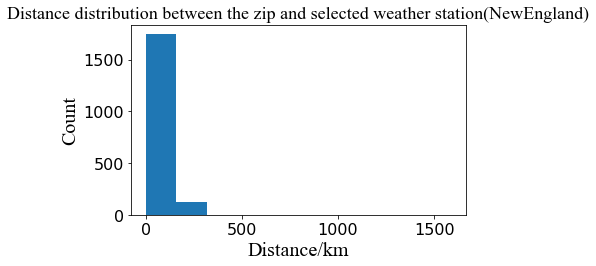

In [25]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}

font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}

figsize = 6,3.5
figure, ax = plt.subplots(figsize=figsize)

plt.hist(Distance_list)

title_name = 'Distance distribution between the zip and selected weather station('+Region_list[region_id]+')'
plt.tick_params(labelsize=16)
plt.title(title_name,font1)
plt.xlabel('Distance/km',font2)
plt.ylabel('Count',font2)
plt.show()

In [26]:
zip_WS_list = df_data['Nearestweatherstationid_sameIECC(From_NREL city list)'].tolist()
count = 0
nrel_city_list = NREL_city['ID1']
for i in range(len(nrel_city_list)):
    if nrel_city_list[i] in zip_WS_list:
        count = count+1

In [27]:
print('For the '+ Region_list[region_id] +', there are ' +str(len(Label_same_eGRID))+' unique zip codes')
print('          '+str(sum(Label_same_state))+' of them can find the weather station at same eGRID area')
print('          '+str(len(Label_same_eGRID) - sum(Label_same_state))+' of them cannot find the weather station at same eGRID area') 
print('          '+str(count) +  ' of '+ str(len(NREL_city)) + ' weather stations needed')


For the NewEngland, there are 1881 unique zip codes
          1430 of them can find the weather station at same eGRID area
          451 of them cannot find the weather station at same eGRID area
          12 of 216 weather stations needed


##  Run the above three times to get CA/TX/NE results, then merge them together

# 4. Merge all three regions, and filter the EMM region


In [120]:
df_data_CA = pd.read_csv('Outputs/Match_WS/Result_ZIPmatchWS_CA_fixCountyIssue'+'_'+keyword2 +'.csv')
df_data_TX = pd.read_csv('Outputs/Match_WS/Result_ZIPmatchWS_TX_fixCountyIssue'+'_'+keyword2 +'.csv')
df_data_NEWE = pd.read_csv('Outputs/Match_WS/Result_ZIPmatchWS_NewEngland_fixCountyIssue'+'_'+keyword2 +'.csv')

df_all_3regions_raw = pd.concat([df_data_CA,df_data_TX,df_data_NEWE])

In [128]:
switch_area = 2 # 0- using all raw data, 1-using state region, 2- use eGRID region 

if switch_area ==0: # Use all raw data
    keyword = 'RawDMP'    
    df_all_3regions = df_all_3regions_raw.copy()
    df_all_3regions.to_csv('Outputs/Match_WS/Result_ALLZIP(' + keyword + ')'+'_'+keyword2 +'.csv',index=False)  
elif switch_area ==1: # Use the filtered data based on the state name
    keyword = 'State'
    df_all_3regions = pd.DataFrame()
    for state in ['CA','TX','CT','MA','ME','NH','RI','VT']:
        df_temp = df_all_3regions_raw[df_all_3regions_raw['SITE_STATE']==state]
        df_all_3regions = pd.concat([df_all_3regions,df_temp])
    df_all_3regions.to_csv('Outputs/Match_WS/Result_ALLZIP(' + keyword + ')'+'_'+keyword2 +'.csv',index=False)        
elif  switch_area ==2:# Use the filtered data based on the eGRID region
    keyword = 'eGRID'    
    df_all_3regions = pd.DataFrame()
    for eGRID in ['CAMX','ERCT','NEWE']:
        df_temp = df_all_3regions_raw[df_all_3regions_raw['eGRID Region_assigned']==eGRID]
        df_all_3regions = pd.concat([df_all_3regions,df_temp])
    df_all_3regions.to_csv('Outputs/Match_WS/Result_ALLZIP(' + keyword + ')'+'_'+keyword2 +'2.csv',index=False)            

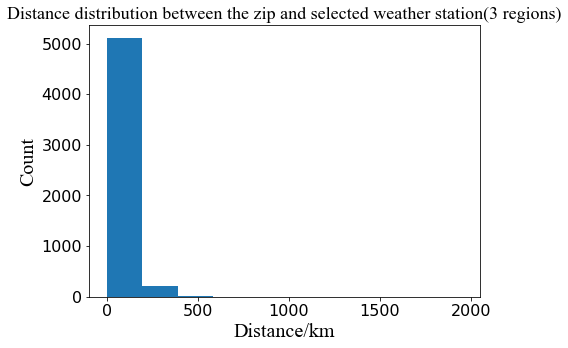

In [32]:
figsize = 7,5
figure, ax = plt.subplots(figsize=figsize)
plt.hist(df_all_3regions['Distance'].tolist())
title_name = 'Distance distribution between the zip and selected weather station(3 regions)'
plt.tick_params(labelsize=16)
plt.title(title_name,font1)
plt.xlabel('Distance/km',font2)
plt.ylabel('Count',font2)
plt.show()

In [33]:
print('The needed weather staion number for 3 regions is ' + str(len(df_all_3regions['Nearestweatherstationid_sameIECC(From_NREL city list)'].unique())))
print('The needed weather staion number for CA regions is ' + str(len(df_data_CA['Nearestweatherstationid_sameIECC(From_NREL city list)'].unique())))
print('The needed weather staion number for TX regions is ' + str(len(df_data_TX['Nearestweatherstationid_sameIECC(From_NREL city list)'].unique())))
print('The needed weather staion number for NEWE regions is ' + str(len(df_data_NEWE['Nearestweatherstationid_sameIECC(From_NREL city list)'].unique())))

The needed weather staion number for 3 regions is 45
The needed weather staion number for CA regions is 23
The needed weather staion number for TX regions is 50
The needed weather staion number for NEWE regions is 12


# 5. Add the label info to NREL city file

In [132]:
Label_city_used_list = []
zip_count_list = []
nrel_city_selected_list = df_all_3regions['Nearestweatherstationid_sameIECC(From_NREL city list)'].unique().tolist()
for i in range(len(nrel_city_list)):
    if nrel_city_list[i] in nrel_city_selected_list:
        Label_city_used_list.append('NEED')
    else:
        Label_city_used_list.append('NONEED')
    
    zip_count = len(df_all_3regions[df_all_3regions['Nearestweatherstationid_sameIECC(From_NREL city list)'] == nrel_city_list[i]])
    zip_count_list.append(zip_count)
    
NREL_city['Need or not'] = Label_city_used_list    
NREL_city['# of zip(using this weather station)'] = zip_count_list    

In [133]:
NREL_city.to_csv('Outputs/Match_WS/Result_NREL_weather_locations(' + keyword + ')'+'_'+keyword2 +'2.csv',index=False)

In [150]:
# shapely.geometry.Point(-122.216825,37.748272).within(data.loc[3, 'geometry'])

# 6. Additional code, only need to be launched when the NREL result format is not following the aggred format
## Mapping RNEL cityies across different formats - Data 1 and Data 2

In [28]:
NREL_allcity = pd.read_csv('Inputs/Result_NREL_weater_locations(eGRID)_trimmed_allassigned.csv')
NREL_46city = NREL_allcity[NREL_allcity['Need or not']=='NEED']
NREL_46city.index = range(len(NREL_46city))

In [29]:
df_enable = pd.read_csv('Inputs/Mapping_NREL_City_formats.csv')
ID1_verify = df_enable['ID1']
enable_list = df_enable['Enable']
NREL_46city['ID1_vefy'] = ID1_verify
NREL_46city['Enable'] = enable_list

/Users/congzhang/virtualenvs/EMP_env_P3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/congzhang/virtualenvs/EMP_env_P3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:
df_nrelstock_test = pd.read_csv('../Shared Drives/NREL_ResStock_0617/lbnl_geb_support_revamp4.csv')

In [30]:
## Create df for 36 weather stations
## prepare for the convert between the epw formats
## From data 2 to data 1, now extract data 2, and prepare the mapping file
## Data 1(Target):  0192307_US_CA_Los_Angeles_6037_0-20000-0-72297_33.85_-118.18_NSRDB_2.0.1_AMY.epw
## Data 2:  USA_CA_Los.Angeles.Intl.AP.722950_TMY3.epw
    
ResStock_list = df_nrelstock_test['epw'].unique().tolist()
WS_id_list = []
for file_name in ResStock_list:
    WS_id_list.append(int(file_name.split('_',3)[2].split('.')[-1]))

    
df_wsid = pd.read_csv('Inputs/isd-history.csv')
isd_id = df_wsid['USAF'].tolist()
isd_lat= df_wsid['LAT'].tolist()
isd_lon= df_wsid['LON'].tolist()

lat_list = []
lon_list = []
for ws_id in WS_id_list:
    index_id = isd_id.index(ws_id)
    lat_list.append(isd_lat[index_id])
    lon_list.append(isd_lon[index_id])
    
result_wsid = pd.DataFrame()
result_wsid['epw'] = ResStock_list
result_wsid['USAF'] = WS_id_list
result_wsid['lat'] = lat_list
result_wsid['lon'] = lon_list

In [31]:
epw_list = []
USAF_list = []
lat_list = []
lon_list = []

for i in range(len(NREL_46city)):
    lat_1 = NREL_46city.loc[i]['Lat']
    lon_1 = NREL_46city.loc[i]['Lon']
    distance_list = []
    for j in range(0,len(result_wsid)):
        distance = function_distance(lat_1,lon_1,result_wsid.loc[j]['lat'],result_wsid.loc[j]['lon'])
        distance_list.append(distance)
    index_mindistance = distance_list.index(min(distance_list))
    
    epw_list.append(result_wsid.loc[index_mindistance]['epw'])
    USAF_list.append(result_wsid.loc[index_mindistance]['USAF'])
    lat_list.append(result_wsid.loc[index_mindistance]['lat'])
    lon_list.append(result_wsid.loc[index_mindistance]['lon'])
    
NREL_46city['epw'] = epw_list
NREL_46city['USAF'] = USAF_list
NREL_46city['lat'] = lat_list
NREL_46city['lon'] = lon_list


/Users/congzhang/virtualenvs/EMP_env_P3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/congzhang/virtualenvs/EMP_env_P3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/congzhang/virtualenvs/EMP_env_P3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [32]:
NREL_46city.to_csv('Inputs/Mapping_NREL_City_formats_debug.csv',index = False)

In [64]:
NREL_37city = NREL_46city[NREL_46city['Enable']==1]
NREL_37city.head(2)

build_existing_model.location_weather_filename     ID1  US State  \
0  0101017_US_CA_Humboldt_6023_0-20000-0-72594_40...  101017  US    CA   
1  0123959_US_CA_San_Mateo_6081_0-20000-0-72494_3...  123959  US    CA   

      County   ID2              ID3    Lat     Lon Label1  ...  \
0   Humboldt  6023  0-20000-0-72594  40.97 -124.10  NSRDB  ...   
1  San_Mateo  6081  0-20000-0-72494  37.61 -122.42  NSRDB  ...   

  Is same between EMM and eGRID Need or not  \
0                             1        NEED   
1                             1        NEED   

  # of zip(using this weather station) NOTES ID1_vefy  Enable  \
0                                   36   NaN   101017       1   
1                                  313   NaN   123959       1   

                                         epw    USAF     lat      lon  
0              USA_CA_Arcata.725945_2016.epw  725945  40.978 -124.109  
1  USA_CA_San.Francisco.Intl.724940_2016.epw  724940  37.620 -122.365  

[2 rows x 25 columns]

In [73]:
df_nrelstock_test.head(1000).to_csv('test_delete.csv')

## 6.2 Compare the count distribution in resstock vs comstock

In [67]:
df_resstock_count = pd.read_csv('Inputs/brief_summary_full_0617.csv')
df_mapping_ComToGeneral = pd.read_csv('Inputs/Mapping_NREL_ResStock_ComStock_weather_stations.csv')

In [68]:
county_id_list = []
for i in range(len(df_resstock_count)):
    ws_resstock = df_resstock_count.iloc[i]['weather_station']
    ws_general = NREL_37city['build_existing_model.location_weather_filename'].tolist()[NREL_37city['epw'].tolist().index(ws_resstock)]
    ws_comstock_index = df_mapping_ComToGeneral['build_existing_model.location_weather_filename'].tolist().index(ws_general)
    ws_comstock_county_id = df_mapping_ComToGeneral['matched ComStock Weather Station(county_id)'].tolist()[ws_comstock_index]
    county_id_list.append(ws_comstock_county_id)
df_resstock_count['comstock_county_id'] = county_id_list

In [71]:
df_resstock_count.to_csv('Inputs/brief_summary_full_0617_forpivot.csv')

## 7. For Brian - Generate a map file contain zip, station id, county

In [51]:
map_info_raw = pd.read_csv('Outputs/Match_WS/Result_ALLZIP(eGRID)_RMsubregions.csv')
NREL_46city = pd.read_csv('Inputs/Mapping_NREL_City_formats.csv')

In [52]:
map_info = pd.DataFrame()

map_info['ZIP'] = map_info_raw['SITE_ZIP']

# map_info['SITE_STATE'] = map_info_raw['SITE_STATE']

In [53]:
result_list = []
wsid_formal = NREL_46city['USAF'].tolist()
wsid_list = map_info_raw['Nearestweatherstationid_sameIECC(From_NREL city list)'].tolist()
for i in range(len(wsid_list)):
    station_id = wsid_list[i]
    if station_id == 120110:
        print(str(station_id)+' is replaced by the ')
        station_id =101017   
        print(str(station_id))
    elif station_id == 210592:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))
    elif station_id == 749293:
        print(str(station_id)+' is replaced by the ')
        station_id =215768   
        print(str(station_id))        

    elif station_id == 142626:
        print(str(station_id)+' is replaced by the ')
        station_id =165368   
        print(str(station_id))
    elif station_id == 247402:
        print(str(station_id)+' is replaced by the ')
        station_id =215768
        print(str(station_id))
    elif station_id == 368181:
        print(str(station_id)+' is replaced by the ')
        station_id =268333
        print(str(station_id))
    elif station_id == 434720:
        print(str(station_id)+' is replaced by the ')
        station_id =544930
        print(str(station_id))
    elif station_id == 742491:
        print(str(station_id)+' is replaced by the ')
        station_id =753608
        print(str(station_id))
    elif station_id == 766075:
        print(str(station_id)+' is replaced by the ')
        station_id =721297   
        print(str(station_id))    
    index_id = NREL_46city['ID1'].tolist().index(station_id)
    result_list.append(wsid_formal[index_id])
map_info['Weather Station'] =  result_list
map_info['County'] = map_info_raw['County']
map_info.to_csv('Mapping.csv',index = False)

120110 is replaced by the 
101017
142626 is replaced by the 
165368
247402 is replaced by the 
215768
210592 is replaced by the 
215768
210592 is replaced by the 
215768
210592 is replaced by the 
215768
142626 is replaced by the 
165368
247402 is replaced by the 
215768
247402 is replaced by the 
215768
247402 is replaced by the 
215768
247402 is replaced by the 
215768
247402 is replaced by the 
215768
210592 is replaced by the 
215768
247402 is replaced by the 
215768
247402 is replaced by the 
215768
247402 is replaced by the 
215768
742491 is replaced by the 
753608
742491 is replaced by the 
753608
434720 is replaced by the 
544930
766075 is replaced by the 
721297
766075 is replaced by the 
721297
434720 is replaced by the 
544930
434720 is replaced by the 
544930


## 8. Calculate the average sqft of ResStock full database

In [4]:
# brief_summary = pd.read_csv('Inputs/brief_summary_test_0507.csv') # This file is from Brian
brief_summary = pd.read_csv('Inputs/brief_summary_full_0617.csv') # This file is from Brian

result_average_sqft_detail = pd.DataFrame()

In [5]:
weather_station_list = []
building_type_list = []
num_buildings_list = []
num_unit_list = []
num_with_ac_list = []
tot_cond_ft_2_list = []


for epw in brief_summary['weather_station'].unique().tolist():
    a= brief_summary[brief_summary['weather_station']==epw]
    for bt in a['building_type'].unique().tolist():
        b = a[a['building_type']==bt]
        c = b.groupby('building_type').sum()
        
        weather_station_list.append(epw)
        building_type_list.append(bt)
        num_buildings_list.append(c.iloc[0]['num_buildings'])
        num_unit_list.append(c.iloc[0]['num_units'])
        num_with_ac_list.append(c.iloc[0]['num_with_ac'])
        tot_cond_ft_2_list.append(c.iloc[0]['tot_cond_ft_2'])

# Begin to calculate the average sqft
tot_cond_ft_2_mean_list = list(map(lambda x: x[0]/x[1], zip(tot_cond_ft_2_list,num_unit_list)))

result_average_sqft_detail['weather_station'] = weather_station_list
result_average_sqft_detail['building_type'] = building_type_list
result_average_sqft_detail['num_buildings'] = num_buildings_list
result_average_sqft_detail['num_units'] = num_unit_list
result_average_sqft_detail['num_with_ac'] = num_with_ac_list
result_average_sqft_detail['tot_cond_ft_2'] = tot_cond_ft_2_list
result_average_sqft_detail['tot_cond_ft_2_mean'] = tot_cond_ft_2_mean_list


In [6]:
result_average_sqft_detail.to_csv('Inputs/AverageSQFT_summary_ResStock_full_0617.csv')

In [187]:
tem_a = result_average_sqft_detail[result_average_sqft_detail['weather_station']=='USA_CA_Arcata.725945_2016.epw']
tem_b = tem_a[tem_a['building_type']=='Multi-Family with 5+ Units']
tem_b

weather_station               building_type  num_buildings  \
2  USA_CA_Arcata.725945_2016.epw  Multi-Family with 5+ Units           48.0   

   num_with_ac  tot_cond_ft_2   tot_ft_2  tot_cond_ft_2_mean  tot_ft_2_mean  
2         38.0       428800.0  264468.24         8933.333333       5509.755

In [189]:
key_string = 'tot_ft_2_mean'
tem_b.iloc[0][key_string]

5509.755000000002

## 9 Convert the prequest to csv file

In [19]:
for upgrade in range(0,1):
    table2 = pq.read_table('Shared Drives/NREL_ResStock_0306/results_up0' + str(upgrade) +'.parquet')
    df_table2 = table2.to_pandas()
    df_table2.to_csv('Shared Drives/NREL_ResStock_0306/results_up0' + str(upgrade) +'.csv',index = False)
    print('Building number in upgrade scenario ' + str(upgrade))
    print(len(df_table2))
    

Building number in upgrade scenario 0
137047


In [25]:
df_table2_MF_4 = df_table2[df_table2['build_existing_model.geometry_building_type_recs']=='Multi-Family with 2 - 4 Units']
df_table2_MF_5 = df_table2[df_table2['build_existing_model.geometry_building_type_recs']=='Multi-Family with 5+ Units']

In [29]:
df_table2_MF_4['build_existing_model.geometry_house_size']

0            0-1499
12           0-1499
21           0-1499
38           0-1499
50           0-1499
            ...    
136975    1500-2499
136997    2500-3499
137029    2500-3499
137031       0-1499
137032    1500-2499
Name: build_existing_model.geometry_house_size, Length: 12670, dtype: object

In [30]:
df_table2_MF_5['build_existing_model.geometry_house_size']

7             3500+
9         1500-2499
35        2500-3499
43        1500-2499
53            3500+
            ...    
137024        3500+
137030       0-1499
137035    2500-3499
137039       0-1499
137045       0-1499
Name: build_existing_model.geometry_house_size, Length: 19014, dtype: object

# 10 Read NREL file and generate the sum() (for the scaling file)

In [5]:
def Cal_ResStock_sum(df_nrelstock_test2):
    WS_list = []
    UT_list = []
    UG_list = []
    EC_list = []
    count = 0
    for WS in df_nrelstock_test2['epw'].unique().tolist():
        count = count + 1
        print('This is the epw number ' + str(count) + ' /(36)')
        a = df_nrelstock_test2[df_nrelstock_test2['epw'] == WS]

        for UT in a['unit_type'].unique().tolist():
            b = a[a['unit_type'] == UT]

            for UG in df_nrelstock_test2['upgrade'].unique().tolist():
                WS_list.append(WS)
                UT_list.append(UT)
                UG_list.append(UG)            
                c = b[b['upgrade'] == UG]            
                EC_list.append(c['Building_Electricity'].sum())

    result_ResStock = pd.DataFrame()
    result_ResStock['epw'] = WS_list
    result_ResStock['unit_type'] = UT_list
    result_ResStock['upgrade'] = UG_list
    result_ResStock['Building_Electricity sum'] = EC_list

    return result_ResStock


def Cal_ComStock_sum(df_nrelstock_test2):
    WS_list = []
    UT_list = []
    UG_list = []
    EC_list = []
    count = 0
    for WS in df_nrelstock_test2['weather_station'].unique().tolist():
        count = count + 1
        print('This is the epw number ' + str(count) + ' /(36)')
        a = df_nrelstock_test2[df_nrelstock_test2['weather_station'] == WS]

        for UT in a['building_type'].unique().tolist():
            b = a[a['building_type'] == UT]

            for UG in df_nrelstock_test2['10k_1_climate_zone_upgrade'].unique().tolist():
                WS_list.append(WS)
                UT_list.append(UT)
                UG_list.append(UG)            
                c = b[b['10k_1_climate_zone_upgrade'] == UG]            
                EC_list.append(c['out.electricity.total.energy_consumption'].sum())

    result_ResStock = pd.DataFrame()
    result_ResStock['weather_station'] = WS_list
    result_ResStock['building_type'] = UT_list
    result_ResStock['10k_1_climate_zone_upgrade'] = UG_list
    result_ResStock['Building_Electricity sum'] = EC_list

    return result_ResStock

In [6]:
# Calculate the ResStock sum
# df_nrelstock_test1 = pd.read_csv('../Shared Drives/NREL_ResStock_Test/Test12_perbldgresults.csv')
# df_nrelstock_test2 = pd.read_csv('../Shared Drives/NREL_ResStock_0306/LBNL run results.csv')
# df_nrelstock_test2 = pd.read_csv('../Shared Drives/NREL_ResStock_0617/lbnl_geb_support_revamp4.csv')

result_ResStock = Cal_ResStock_sum(df_nrelstock_test2)
result_ResStock.to_csv('ResStock Result all-full.csv',index = False)
result_scalingfactor = result_ResStock[result_ResStock['upgrade']==0]
result_scalingfactor.index = range(len(result_ResStock[result_ResStock['upgrade']==0]))
result_scalingfactor.to_csv('For_ScalingFactor_begin_Res_0617.csv',index = False)

This is the epw number 1 /(36)
This is the epw number 2 /(36)
This is the epw number 3 /(36)
This is the epw number 4 /(36)
This is the epw number 5 /(36)
This is the epw number 6 /(36)
This is the epw number 7 /(36)
This is the epw number 8 /(36)
This is the epw number 9 /(36)
This is the epw number 10 /(36)
This is the epw number 11 /(36)
This is the epw number 12 /(36)
This is the epw number 13 /(36)
This is the epw number 14 /(36)
This is the epw number 15 /(36)
This is the epw number 16 /(36)
This is the epw number 17 /(36)
This is the epw number 18 /(36)
This is the epw number 19 /(36)
This is the epw number 20 /(36)
This is the epw number 21 /(36)
This is the epw number 22 /(36)
This is the epw number 23 /(36)
This is the epw number 24 /(36)
This is the epw number 25 /(36)
This is the epw number 26 /(36)
This is the epw number 27 /(36)
This is the epw number 28 /(36)
This is the epw number 29 /(36)
This is the epw number 30 /(36)
This is the epw number 31 /(36)
This is the epw n

In [ ]:
# Calculate the ComStock sum
df_comstock_test = pd.read_csv('../Shared Drives/NREL_ComStock/8760_dry_run/Converted/Baseline-8760_v4.csv')

result_ComStock = Cal_ComStock_sum(df_comstock_test)
result_ComStock.to_csv('ComStock Result all-full.csv',index = False)
result_scalingfactor = result_ComStock[result_ComStock['10k_1_climate_zone_upgrade']==0]
result_scalingfactor.index = range(len(result_scalingfactor))
result_scalingfactor.to_csv('For_ScalingFactor_begin_Com.csv',index = False)

In [ ]:
# USeless
for epw in result_ResStock['epw'].unique().tolist():
    a = result_ResStock[result_ResStock['epw']==epw]
    
    for ut in a['unit_type'].unique().tolist():
        b = a[a['unit_type']==ut]
        c0 = b[b['upgrade']==0].iloc[0][3]
        c1 = b[b['upgrade']==1].iloc[0][3]
        c2 = b[b['upgrade']==2].iloc[0][3]
        c3 = b[b['upgrade']==3].iloc[0][3]
        c4 = b[b['upgrade']==4].iloc[0][3]
        c5 = b[b['upgrade']==5].iloc[0][3]
        if c0 ==max(c0,c1,c2,c3,c4,c5) and c5==min(c0,c1,c2,c3,c4,c5):
            pass
        else:
            print(epw + ' ' + ut )   

## 11. Check the NREL result whether the anverage load = sum(each end user)
## Generate the ratio for one sample epw

In [ ]:
df_nrelstock_test = df_nrelstock_test2.copy()

WS = 'USA_CA_San.Francisco.Intl.724940_2016.epw'
aa = df_nrelstock_test[df_nrelstock_test['epw'] == WS]
Build_category = 'Mobile Home'

for ut in aa['unit_type'].unique().tolist():
    bb = aa[aa['unit_type']== ut]
    cc = bb[bb['upgrade'] == 0] 

    end_use_sum = 0
    end_use_list = []
    load_KWh_list = []
    ratio_list = []
    cum_ratio_list = []

    total_build_load = cc['Building_Electricity'].sum()
    for cate in cc.columns.tolist()[4:]:
        if cate=='Interior_Equipment':
            pass
        elif cate=='Building_Electricity':
            end_use_list.append(cate)
            load_KWh_list.append(total_build_load)
            ratio_list.append(100)
            cum_ratio_list.append(100)
        else:
            temp_end_cum = cc[cate].sum()
            end_use_sum = end_use_sum + temp_end_cum
            end_use_list.append(cate)
            load_KWh_list.append(temp_end_cum)
            ratio_list.append(temp_end_cum/total_build_load*100)
            cum_ratio_list.append(end_use_sum/total_build_load*100)

    result_enduse = pd.DataFrame()
    result_enduse['End use type'] = end_use_list
    result_enduse['Cumu_load_KWh'] = load_KWh_list
    result_enduse['End use Ratio/%'] = ratio_list
    result_enduse['End use Ratio(Cumulative)/%'] = cum_ratio_list
    result_enduse.to_csv('Result_enduseRatio_'+ ut + '('+ WS +').csv',index = False)

    gap = end_use_sum - cc['Building_Electricity'].sum()
    if gap <0.01:
        print('Matched(' + ut + ')')
        print('    Absolute gap value is: ' + str(gap))

# 12. Check the consistance 

In [ ]:
if Region =='CA':
    raw = pd.read_csv('demo_gross_load_CA_LHComb.csv')
    delta = list(map(lambda x: x[0] - x[1], zip(systemload_new['Raw EIA load/MW'].tolist()[0:-1],raw['Raw EIA load/MW'].tolist()[1:])))
    plt.plot(delta)
    plt.show()
    a = systemload_new['scaled_res_kwh_nighttime0'].sum()/(systemload_new['Daytime EIA load/MW'].sum())
    b = raw['scaled_res_kwh_nighttime0'].sum()/(raw['Daytime EIA load/MW'].sum())
    print(a/1000)
    print(abs(a/b - 1) <=0.0001)
else:
    a = systemload_new['scaled_res_kwh_nighttime0'].sum()/(systemload_new['Daytime EIA load/MW'].sum())
    print(abs(a/1000-K_Res) <=0.0001)

# 13. Check the aggregated end use ratio
## 13.1 Calculate the aggregated load based on the scaling factors

In [ ]:
df_scaling_factor=pd.read_csv('ScalingFactor(DryRun_ResStock_Data)_'+Region+'.csv')
# df_scaling_factor = df_ScalingFactor.copy()
result = pd.DataFrame()
result['Date/Time'] = systemload_new['Date/Time']
result.index = systemload_new.index
    
for upgrade in [0,1,2,3,4,5]:
    print('======This is upgrade ' + str(upgrade) + ' /(5)'+'=====')
    df_nrelstock_test_0 = df_nrelstock_test2[df_nrelstock_test2['upgrade'] == upgrade]
    count = 0
    cum_count = 0
    for WS in df_nrelstock_test_0['epw'].unique().tolist():
        count = count + 1
        if count % 6 ==0:
            print('This is the epw number ' + str(count) + ' /(36)')
        a = df_nrelstock_test_0[df_nrelstock_test_0['epw'] == WS]

        for UT in a['unit_type'].unique().tolist():
            cum_count = cum_count + 1
            b = a[a['unit_type'] == UT]

            tem_a = df_scaling_factor[df_scaling_factor['epw']==WS]
            tem_b = tem_a[tem_a['unit_type']==UT]
            factor = tem_b.iloc[0][4]*tem_b.iloc[0][5]*tem_b.iloc[0][6]

            for end_use in a.columns.tolist()[4:]:
                if cum_count ==1:
                    result[end_use] = [x*factor for x in b[end_use].tolist()]
                else:
                    result[end_use] = list(map(lambda x:x[0]+x[1]*factor, zip(result[end_use].tolist(),b[end_use].tolist())))

    cc = result.copy()
    end_use_sum = 0
    end_use_list = []
    load_KWh_list = []
    ratio_list = []
    cum_ratio_list = []

    total_build_load = cc['Building_Electricity'].sum()
    for cate in cc.columns.tolist()[1:]:
        if cate=='Interior_Equipment':
            pass
        elif cate=='Building_Electricity':
            end_use_list.append(cate)
            load_KWh_list.append(total_build_load)
            ratio_list.append(100)
            cum_ratio_list.append(100)
        else:
            temp_end_cum = cc[cate].sum()
            end_use_sum = end_use_sum + temp_end_cum
            end_use_list.append(cate)
            load_KWh_list.append(temp_end_cum)
            ratio_list.append(temp_end_cum/total_build_load*100)
            cum_ratio_list.append(end_use_sum/total_build_load*100)
    if upgrade ==0:
        result_enduse = pd.DataFrame()
        result_enduse['End use type'] = end_use_list
    result_enduse['Cumu_load_KWh(Upgrade='+str(upgrade)+')'] = load_KWh_list
    result_enduse['End use percentage(Upgrade='+str(upgrade)+')']= ratio_list
    result_enduse['End use percentage(Cumulative-Upgrade='+str(upgrade)+')']= cum_ratio_list


    gap = end_use_sum - cc['Building_Electricity'].sum()
    if abs(gap) <0.01:
        print('    Matched(upgrade ' + str(upgrade) + ')')
        print('    Absolute gap value is: ' + str(gap))
    else:
        print('    ======Not Matched(upgrade ' + str(upgrade) + ')')
        print('    ======Absolute gap value is: ' + str(gap))    
result_enduse.to_csv('Result_EnduseRatio' + '(Aggregated-TX).csv')    
end1 = datetime.datetime.now()
# print(end1-start1)

## 13.2 Plot the end-use ratio 

In [ ]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}

result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-CA).csv')
figsize = 9,6
figure, ax = plt.subplots(figsize=figsize)
for upgrade in [0,1,2,3,4,5]:
    plt.plot(range(1,33),result_enduse['End use percentage(Upgrade='+str(upgrade)+')'].tolist()[1:],label = 'upgrade' + str(upgrade))

plt.legend(loc=0, prop={'size': 12})
plt.xlabel('End-use types(CA)',font1)
plt.ylabel('Percentage/%',font1)
plt.tick_params(labelsize=15)

result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-TX).csv')
figsize = 9,6
figure, ax = plt.subplots(figsize=figsize)
for upgrade in [0,1,2,3,4,5]:
    plt.plot(range(1,33),result_enduse['End use percentage(Upgrade='+str(upgrade)+')'].tolist()[1:],label = 'upgrade' + str(upgrade))

plt.legend(loc=0, prop={'size': 12})
plt.xlabel('End-use types(TX)',font1)
plt.ylabel('Percentage/%',font1)
plt.tick_params(labelsize=15)

systemload_new = pd.read_csv('Gross_load_CA_scenario_0_VS_5.csv')
result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-CA).csv')  
print('The average residential load(CA-final) is ' + str(systemload_new['scaled_res_kwh'].sum()/1000000/366/24))
print('The average residential load(CA-using scaling) is ' + str(result_enduse['Cumu_load_KWh(Upgrade=0)'].sum()/1000000/366/24))

systemload_new = pd.read_csv('Gross_load_TX_scenario_0_VS_5.csv')
result_enduse = pd.read_csv('Result_EnduseRatio' + '(Aggregated-TX).csv')  
print('The average residential load(TX-final) is ' + str(systemload_new['scaled_res_kwh'].sum()/1000000/366/24))
print('The average residential load(TX-using scaling) is ' + str(result_enduse['Cumu_load_KWh(Upgrade=0)'].sum()/1000000/366/24))


## 14 Check the weather stations(constock vs NREL)

In [68]:
# Read in the NREL city format mapping data 1（useless）
df_weatherstation_formatsMapping = pd.read_csv('Inputs/Mapping_NREL_City_formats.csv')
# df_weatherstation_formatsMapping = df_weatherstation_formatsMapping[df_weatherstation_formatsMapping['Enable']==1]
ws_nrel_list = df_weatherstation_formatsMapping['epw'].tolist()

# Read in the ConStock data
# xls = pd.read_excel(r'Inputs/comstock_weather_file_list.xlsx')
# ws_nrel3000_list = xls['comstock_weather_file_name'].tolist()
df_com_nrel3000 = pd.read_csv('Inputs/comstock_weather_file_list_with_lat_lon.csv')

In [69]:
df_weatherstation_formatsMapping.head(2)

build_existing_model.location_weather_filename     ID1  US State  \
0  0101017_US_CA_Humboldt_6023_0-20000-0-72594_40...  101017  US    CA   
1  0123959_US_CA_San_Mateo_6081_0-20000-0-72494_3...  123959  US    CA   

      County   ID2              ID3    Lat     Lon Label1  ... eGRID Region  \
0   Humboldt  6023  0-20000-0-72594  40.97 -124.10  NSRDB  ...         CAMX   
1  San_Mateo  6081  0-20000-0-72494  37.61 -122.42  NSRDB  ...         CAMX   

  Is same between EMM and eGRID Need or not Enable  \
0                             1        NEED      1   
1                             1        NEED      1   

  # of zip(using this weather station)  NOTES  \
0                                   36    NaN   
1                                  313    NaN   

                                         epw    USAF     lat      lon  
0              USA_CA_Arcata.725945_2016.epw  725945  40.978 -124.109  
1  USA_CA_San.Francisco.Intl.724940_2016.epw  724940  37.620 -122.365  

[2 rows x 24 columns]

In [70]:
df_weatherstation_formatsMapping.head(5)

build_existing_model.location_weather_filename     ID1  US State  \
0  0101017_US_CA_Humboldt_6023_0-20000-0-72594_40...  101017  US    CA   
1  0123959_US_CA_San_Mateo_6081_0-20000-0-72494_3...  123959  US    CA   
2  0138102_US_CA_Sacramento_6067_0-20000-0-72483_...  138102  US    CA   
3  0142626_US_OR_Deschutes_41017_0-20000-0-72692_...  142626  US    OR   
4  0154150_US_CA_Santa_Barbara_6083_0-20000-0-723...  154150  US    CA   

          County    ID2              ID3    Lat     Lon Label1  ...  \
0       Humboldt   6023  0-20000-0-72594  40.97 -124.10  NSRDB  ...   
1      San_Mateo   6081  0-20000-0-72494  37.61 -122.42  NSRDB  ...   
2     Sacramento   6067  0-20000-0-72483  38.49 -121.50  NSRDB  ...   
3      Deschutes  41017  0-20000-0-72692  44.25 -121.18  NSRDB  ...   
4  Santa_Barbara   6083  0-20000-0-72394  34.93 -120.46  NSRDB  ...   

  eGRID Region Is same between EMM and eGRID Need or not Enable  \
0         CAMX                             1        NEED      1   
1         CAMX                             1        NEED      1   
2         CAMX                             1        NEED      1   
3         NWPP                             1        NEED      0   
4         CAMX                             1        NEED      1   

  # of zip(using this weather station)  \
0                                   36   
1                                  313   
2                                  336   
3                                    2   
4                                   88   

                                          NOTES  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3  Can be replaced by Washoe County NV (165368)   
4                                           NaN   

                                          epw    USAF     lat      lon  
0               USA_CA_Arcata.725945_2016.epw  725945  40.978 -124.109  
1   USA_CA_San.Francisco.Intl.724940_2016.epw  724940  37.620 -122.365  
2  USA_CA_Sacramento.Executiv.724830_2016.epw  724830  38.507 -121.495  
3               USA_CA_Arcata.725945_2016.epw  725945  40.978 -124.109  
4   USA_CA_Santa.Maria.Public.723940_2016.epw  723940  34.899 -120.449  

[5 rows x 24 columns]

In [72]:
df_com_nrel3000_county_id = df_com_nrel3000['county_id'].tolist()
df_com_nrel3000_name= df_com_nrel3000['comstock_weather_file_name'].tolist()
df_com_nrel3000_lat = df_com_nrel3000['latitude'].tolist()
df_com_nrel3000_lon = df_com_nrel3000['longitude'].tolist()

matched_com_county_id_list = []
matched_com_wsname = []
matched_com_ws_lat = []
matched_com_ws_lon = []

for i in range(len(df_weatherstation_formatsMapping)):
    nrel_lat = df_weatherstation_formatsMapping.loc[i]['Lat']
    nrel_lon = df_weatherstation_formatsMapping.loc[i]['Lon']

    dis_list = list(map(lambda x: abs(nrel_lat-x[0]) + abs(nrel_lon-x[1]), zip(df_com_nrel3000_lat,df_com_nrel3000_lon)))
    dis_smallest= nsmallest(1, dis_list)
    matched_ws_index = dis_list.index(dis_smallest[0])

    matched_com_county_id_list.append(df_com_nrel3000_county_id[matched_ws_index])
    matched_com_wsname.append(df_com_nrel3000_name[matched_ws_index])
    matched_com_ws_lat.append(df_com_nrel3000_lat[matched_ws_index])
    matched_com_ws_lon.append(df_com_nrel3000_lon[matched_ws_index])
        
df_weatherstation_formatsMapping['matched ComStock Weather Station(county_id)'] = matched_com_county_id_list
df_weatherstation_formatsMapping['matched ComStock Weather Station(comstock_weather_file_name)'] = matched_com_wsname
df_weatherstation_formatsMapping['matched ComStock Weather Station(latitude)'] = matched_com_ws_lat
df_weatherstation_formatsMapping['matched ComStock Weather Station(longitude)'] = matched_com_ws_lon

df_weatherstation_formatsMapping.to_csv('Inputs/Mapping_NREL_ResStock_ComStock_weather_stations.csv',index = False)

In [9]:
count = 0

label_list = []
for ws in ws_nrel_list:
    try:
        ws_index = ws_nrel3000_list.index(ws)
        label_list.append(1)
        count = count + 1
    except:
        label_list.append(0)
        print(ws)
        
df_weatherstation_formatsMapping['weather_station_overlapped'] =  label_list    
df_weatherstation_formatsMapping.to_csv('Inputs/Mapping_NREL_City_formats_overlapped.csv',index = False)
print(count)

USA_CA_Sacramento.Executiv.724830_2016.epw
USA_CA_Santa.Maria.Public.723940_2016.epw
USA_CA_Long.Beach.Lb.Airp.722970_2016.epw
USA_CA_Long.Beach.Lb.Airp.722970_2016.epw
USA_CA_Barstow.Daggett.723815_2016.epw
USA_CT_Hartford.Bradley.In.725080_2016.epw
USA_ME_Caribou.Municipal.727120_2016.epw
30


# 15. Calculate the total sqft for each county

In [155]:
# NREL_city_geo = pd.read_csv('Inputs/comstock_weather_file_list_with_lat_lon(splited).csv')
NREL_city_county = pd.read_csv('Inputs/map_FIPs_2016.csv')

NREL_city_region = []
for i in range(len(NREL_city_county)):
    if NREL_city_county.iloc[i]['state_name'] in ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']:
        NREL_city_region.append('NewEngland')
    else:
        NREL_city_region.append(NREL_city_county.iloc[i]['state_name'])
NREL_city_county['Region'] = NREL_city_region

In [188]:
len(NREL_city_county[NREL_city_county['Region']=='NewEngland']['match_location_name_2016'].unique())

46

In [156]:
# Check the county in DMP could find a mapping county in NREL ComStock dataset
Region_list = ['CA','TX','NewEngland']
Region_full_list = ['California','Texas','NewEngland']

for region_id in [0]:
    count = 0
    Region = Region_list[region_id]
    Region_full = Region_full_list[region_id]
    
    dmp_com_s2 =  pd.read_csv('Outputs/s2_'+Region +'_commercial_result_afterMap.csv')
    dmp_com_s2['Region'] = Region_full

    NREL_city_county_state = NREL_city_county[NREL_city_county['Region']==Region_full]
    ws_list = NREL_city_county_state['county_name'].tolist()
    ws_list = [x.lower() for x in ws_list]
    ws_list = [x.replace(' ', '') for x in ws_list]
    matched_ws_list = []
    unmatched_ws_list = []
    for i in range(len(dmp_com_s2)):
        county_name = dmp_com_s2.iloc[i]['County']
        try:
            matched_ws = NREL_city_county_state.iloc[ws_list.index(county_name.lower())]['match_location_name_2016']
        except:
            matched_ws = 'Unknown'
            if county_name not in unmatched_ws_list:
                unmatched_ws_list.append(county_name)
                count = count + 1
        matched_ws_list.append(matched_ws)

    dmp_com_s2['Mapped_NREL_ComStock_WS'] = matched_ws_list
    dmp_com_s2.to_csv('Outputs/s2.1_'+Region +'_commercial_result_afterMap_WSassigned.csv',index = False)
    
    print(Region + '  ' + str(count) + '(missing mapped)')
    print(unmatched_ws_list)

CA  0(missing mapped)
[]


In [249]:
## Check the weather station mapping the counties in different IECC climate zones
Region_list = ['CA','TX','NE']
Region_full_list = ['California','Texas','NewEngland']

IECC_county_region = []
for i in range(len(IECC_Region)):
    if IECC_Region.iloc[i]['State'] in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']:
        IECC_county_region.append('NE')
    else:
        IECC_county_region.append(IECC_Region.iloc[i]['State'])
IECC_Region['Region'] = IECC_county_region

result_ws_list = []
result_state_list = []
result_county_list = []
result_IECC_list = []
result_unique_list = []
result_sqft_sum_list = []
for region_id in [0,1,2]:
    NREL_city_county_state = NREL_city_county[NREL_city_county['Region']==Region_full_list[region_id]]
    Scout_state = IECC_Region[IECC_Region['Region']==Region_list[region_id]]
    county_list = Scout_state['NAME'].tolist()
    ashrae_list = Scout_state['ASHRAE'].tolist()
    df_dmp_state = pd.read_csv('Outputs/s2.1_'+Region_list[region_id] +'_commercial_result_afterMap_WSassigned.csv')
    df_dmp_state_sum = df_dmp_state.groupby('County').sum()
    for ws_name in NREL_city_county_state['match_location_name_2016'].unique().tolist():
        NREL_city_county_state_ws = NREL_city_county_state[NREL_city_county_state['match_location_name_2016']==ws_name]
#         print(ws_name)
        ashrae_list_tem = []
        for county_name in NREL_city_county_state_ws['county_name'].tolist():
#             print(county_name + '    ' +ashrae_list[county_list.index(county_name)])      
            result_ws_list.append(ws_name)
            result_state_list.append(Region_list[region_id])
            result_county_list.append(county_name)
            ashrae = ashrae_list[county_list.index(county_name)]
            result_IECC_list.append(ashrae)
            
            if len(ashrae_list_tem) == 0:
                ashrae_list_tem.append(ashrae)
                
            if ashrae in ashrae_list_tem:
                result_unique_list.append(1)
            else:
                result_unique_list.append(0)
                
            try:
                county_name_UPPER = county_name.replace(' ', '').upper()
                result_sqft_sum_list.append(df_dmp_state_sum.loc[county_name_UPPER]['BUILDING_SQFT'])
            except:
                result_sqft_sum_list.append(0)
result_comparison = pd.DataFrame()
result_comparison['Weather stations'] =   result_ws_list
result_comparison['State'] =   result_state_list
result_comparison['County'] =   result_county_list
result_comparison['IECC climate zone'] =   result_IECC_list
result_comparison['Selected'] =   result_unique_list
result_comparison['COM_SQFT'] =   result_sqft_sum_list
result_comparison.to_csv('Mapping result.csv',index = False)

ws_list = []
county_list = []
same_iecc_label = []
for ws in result_comparison['Weather stations'].unique().tolist():
    result_comparison_samews = result_comparison[result_comparison['Weather stations']==ws]    
    ws_list.append(ws)    
    county_list.append(result_comparison_samews['County'].tolist())
    if len(result_comparison_samews['IECC climate zone'].unique()) >1:
        same_iecc_label.append(0)
    else:
        same_iecc_label.append(1)
result_sameIECC = pd.DataFrame()
result_sameIECC['Weather stations'] =  ws_list
result_sameIECC['Same IECC zones'] =  same_iecc_label
result_sameIECC.to_csv('WS Mapping result(IECC same).csv',index = False)

In [250]:
result_comparison.head()

Weather stations State     County  \
0  USA_CA_Livermore.Municipal.724927_2016.epw    CA    Alameda   
1     USA_NV_Reno.Cannon.Intl.724880_2016.epw    CA     Alpine   
2     USA_NV_Reno.Cannon.Intl.724880_2016.epw    CA     Lassen   
3           USA_CA_Lake.Tahoe.725847_2016.epw    CA     Amador   
4           USA_CA_Lake.Tahoe.725847_2016.epw    CA  Calaveras   

  IECC climate zone  Selected     COM_SQFT  
0                3C         1  187540989.0  
1                6B         1      25189.0  
2                5B         0    1851942.0  
3                4B         1    3043641.0  
4                4B         1    2011339.0

In [252]:
(result_comparison[result_comparison['Selected']==0]['COM_SQFT'].sum())/(result_comparison['COM_SQFT'].sum())

0.024517715928002323

In [254]:
(result_comparison['COM_SQFT'].sum())
(result_comparison[result_comparison['Selected']==0]['COM_SQFT'].sum())

309980149.0

In [240]:
df_dmp_state = pd.read_csv('Outputs/s2.1_'+Region_list[region_id] +'_commercial_result_afterMap_WSassigned.csv')

df_dmp_state.groupby('County').sum().index.tolist()
# df_dmp.head()

df_dmp_state['County'].unique().tolist()

['YUBA',
 'YOLO',
 'TRINITY',
 'SUTTER',
 'STANISLAUS',
 'SONOMA',
 'SIERRA',
 'SHASTA',
 'SANMATEO',
 'SANFRANCISCO',
 'SANBERNARDINO',
 'SACRAMENTO',
 'PLUMAS',
 'PLACER',
 'NEVADA',
 'NAPA',
 'MONO',
 'MADERA',
 'LOSANGELES',
 'KERN',
 'INYO',
 'HUMBOLDT',
 'FRESNO',
 'CALAVERAS',
 'ALPINE',
 'ALAMEDA',
 'TEHAMA',
 'SANTACRUZ',
 'SANJOAQUIN',
 'TULARE',
 'SOLANO',
 'SANLUISOBISPO',
 'MONTEREY',
 'LAKE',
 'KINGS',
 'GLENN',
 'CONTRACOSTA',
 'COLUSA',
 'SANTACLARA',
 'SANTABARBARA',
 'SANDIEGO',
 'VENTURA',
 'MODOC',
 'LASSEN',
 'SANBENITO',
 'ELDORADO',
 'SISKIYOU',
 'BUTTE',
 'ORANGE',
 'RIVERSIDE',
 'TUOLUMNE',
 'MERCED',
 'MARIN',
 'AMADOR',
 'MARIPOSA']

In [ ]:
# ## Compare and get the County ID difference between 3057 weather stations files supplied by NREL
# count = 0
# df_miss_countyID = pd.DataFrame()
# for i in range(len(NREL_city_county)):
#     county_id = NREL_city_county['original_FIP'].tolist()[i]
#     if county_id in NREL_city_geo['county_id'].tolist():
#         pass
#     else:
#         count = count + 1
#         df_miss_countyID = pd.concat([df_miss_countyID,NREL_city_county.iloc[i:i+1]])
# print(str(count))
# df_miss_countyID.to_csv('CountyNotLat.csv',index = False)

# count = 0
# df_miss_countyID = pd.DataFrame()
# for i in range(len(NREL_city_geo)):
#     county_id = NREL_city_geo['county_id'].tolist()[i]
#     if county_id in NREL_city_county['original_FIP'].tolist():
#         pass
#     else:
#         count = count + 1
#         df_miss_countyID = pd.concat([df_miss_countyID,NREL_city_geo.iloc[i:i+1]])
# print(str(count))
# df_miss_countyID.to_csv('LatNotCounty.csv',index = False)

# 16 EE customied scenarios

In [81]:
Region_list = ['CA','TX','NewEngland','MA']
region_id = 0 #0,1,2,3

df_Scenario = pd.read_csv('EE_scenarios.csv')
Region_res = pd.read_csv('All_Residential_load_'+Region_list[region_id]+'.csv')
Region_com = pd.read_csv('All_Commercial_load_'+Region_list[region_id]+'.csv')

In [82]:
for i in range(len(df_Scenario.Scenario.tolist())):
    scenario_name = df_Scenario.Scenario.tolist()[i]
    df_new = list(map(lambda x: x[0]*df_Scenario.iloc[i][1]+x[1]*df_Scenario.iloc[i][2]+x[2]*df_Scenario.iloc[i][3]+x[3]*df_Scenario.iloc[i][4]+x[4]*df_Scenario.iloc[i][5]+x[5]*df_Scenario.iloc[i][6],
             zip(Region_res['RES_Base/KWh'].tolist(),Region_res['RES_EquipmentOnly/KWh'].tolist(),Region_res['RES_ControlOnly/KWh'].tolist(),Region_res['RES_EnvelopeOnly/KWh'].tolist(),Region_res['RES_Control_Envelope/KWh'].tolist(),Region_res['RES_All_Upgrades/KWh'].tolist())))
    Region_res[scenario_name] = df_new
    
df_res_average_9sce = Region_res.groupby('Hour').mean()

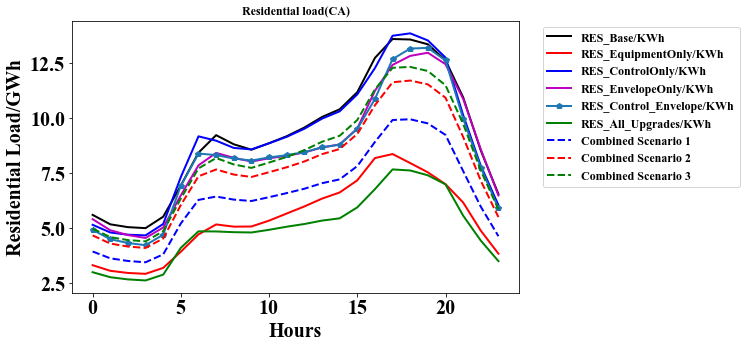

In [85]:
Region = 'CA'
title_name = 'Residential load('+Region+ ')'
figsize = 8,5
figure, ax = plt.subplots(figsize=figsize)
hours= [x for x in range(0,24)]
kW_GW_multip = 0.000001

A,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[3]]*kW_GW_multip,'-k',label=df_res_average_9sce.columns[3],linewidth=2.0)
B,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[4]]*kW_GW_multip,'-r',label=df_res_average_9sce.columns[4],linewidth=2.0)
C,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[5]]*kW_GW_multip,'-b',label=df_res_average_9sce.columns[5],linewidth=2.0)
D,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[6]]*kW_GW_multip,'-m',label=df_res_average_9sce.columns[6],linewidth=2.0)
E,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[7]]*kW_GW_multip,'-p',label=df_res_average_9sce.columns[7],linewidth=2.0)
F,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[8]]*kW_GW_multip,'-g',label=df_res_average_9sce.columns[8],linewidth=2.0)
G,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[9]]*kW_GW_multip,'--b',label=df_res_average_9sce.columns[9],linewidth=2.0)
H,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[10]]*kW_GW_multip,'--r',label=df_res_average_9sce.columns[10],linewidth=2.0)
I,=plt.plot(hours,df_res_average_9sce[df_res_average_9sce.columns[11]]*kW_GW_multip,'--g',label=df_res_average_9sce.columns[11],linewidth=2.0)

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 12,
}
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
legend = plt.legend(handles=[A,B,C,D,E,F,G,H,I],prop=font1, bbox_to_anchor=[1.04,1])
# legend = plt.legend(handles=[G,H,I],prop=font1, bbox_to_anchor=[1.04,1])

plt.tick_params(labelsize=20)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.xlabel('Hours',font2)
plt.ylabel('Residential Load/GWh',font2)
plt.title(title_name,font1) 
plt.show()